# Generate dataset

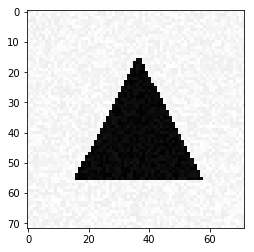

In [2]:
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




In [3]:
#Generate training set
from keras.utils import np_utils
[X_train, Y_train] = generate_dataset_classification(300, 20)
#convert Y_train to be compatible with the model
Y_train=np_utils.to_categorical(Y_train)

Using TensorFlow backend.


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


# stochastic gradient descent optimizer

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
nb_neurons = 3
SGD_model = Sequential([Dense(nb_neurons, input_dim=X_train.shape[1]),Activation('sigmoid')])
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.5,nesterov=True)
SGD_model.compile(loss='mean_squared_error',optimizer=sgd,metrics=['accuracy'])
SGD_model.fit(X_train, Y_train, epochs=30, batch_size=30)

Epoch 1/30
300/300 [==============================] - 1s 4ms/step - loss: 0.2373 - acc: 0.3733
Epoch 2/30
300/300 [==============================] - 0s 273us/step - loss: 0.1976 - acc: 0.5233
Epoch 3/30
300/300 [==============================] - 0s 270us/step - loss: 0.1645 - acc: 0.6500
Epoch 4/30
300/300 [==============================] - 0s 257us/step - loss: 0.1553 - acc: 0.6967
Epoch 5/30
300/300 [==============================] - 0s 283us/step - loss: 0.1340 - acc: 0.7400
Epoch 6/30
300/300 [==============================] - 0s 270us/step - loss: 0.1208 - acc: 0.7967
Epoch 7/30
300/300 [==============================] - 0s 333us/step - loss: 0.1150 - acc: 0.7867
Epoch 8/30
300/300 [==============================] - 0s 316us/step - loss: 0.1198 - acc: 0.8000
Epoch 9/30
300/300 [==============================] - 0s 286us/step - loss: 0.1112 - acc: 0.7567
Epoch 10/30
300/300 [==============================] - 0s 280us/step - loss: 0.1027 - acc: 0.8033
Epoch 11/30
300/300 [==========

In [54]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
SGD_model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

# Adam optimizer

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

nb_neurons = 3
Adam_model = Sequential([Dense(nb_neurons, input_dim=X_train.shape[1]),Activation('sigmoid')])
Adam_model.add(Activation("softmax"))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
Adam_model.compile(loss='mean_squared_error',optimizer=adam,metrics=['accuracy'])
Adam_model.fit(X_train, Y_train, epochs=30, batch_size=30)

Epoch 1/30
300/300 [==============================] - 1s 4ms/step - loss: 0.2161 - acc: 0.4367
Epoch 2/30
300/300 [==============================] - 0s 283us/step - loss: 0.1876 - acc: 0.6033
Epoch 3/30
300/300 [==============================] - 0s 300us/step - loss: 0.1638 - acc: 0.7200
Epoch 4/30
300/300 [==============================] - 0s 367us/step - loss: 0.1485 - acc: 0.8067
Epoch 5/30
300/300 [==============================] - 0s 328us/step - loss: 0.1376 - acc: 0.8567
Epoch 6/30
300/300 [==============================] - 0s 310us/step - loss: 0.1325 - acc: 0.8933
Epoch 7/30
300/300 [==============================] - 0s 290us/step - loss: 0.1305 - acc: 0.9033
Epoch 8/30
300/300 [==============================] - 0s 326us/step - loss: 0.1222 - acc: 0.9433
Epoch 9/30
300/300 [==============================] - 0s 316us/step - loss: 0.1240 - acc: 0.9100
Epoch 10/30
300/300 [==============================] - 0s 336us/step - loss: 0.1152 - acc: 0.9533
Epoch 11/30
300/300 [==========

In [50]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
Adam_model.predict(X_test)

array([[0.21194157, 0.5761169 , 0.21194157]], dtype=float32)

# Visualization of the solution

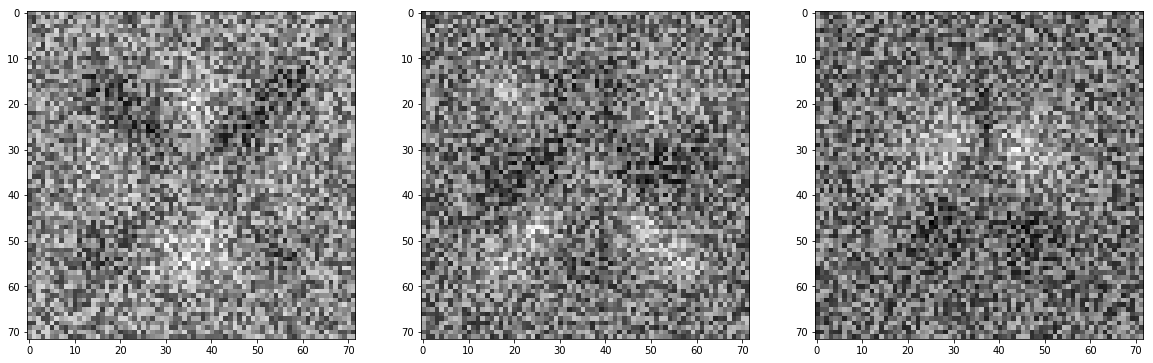

In [55]:
Column1=SGD_model.get_weights()[0][:,0]
Column2=SGD_model.get_weights()[0][:,1]
Column3=SGD_model.get_weights()[0][:,2]
fig,(ax0,ax1,ax2)=plt.subplots(ncols=3,figsize=(20,20))
ax0.imshow(Column1.reshape(72,72),cmap='gray')
ax1.imshow(Column2.reshape(72,72),cmap='gray')
ax2.imshow(Column3.reshape(72,72),cmap='gray')

Visualization of Adam model

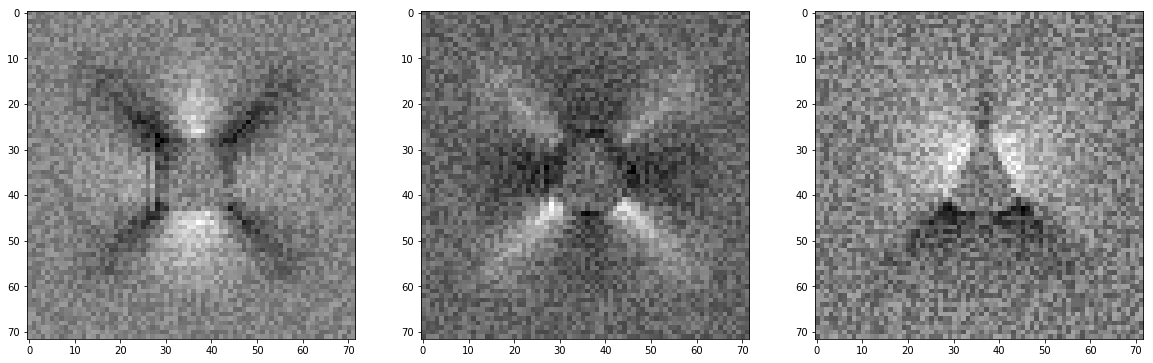

In [52]:
Column1=Adam_model.get_weights()[0][:,0]
Column2=Adam_model.get_weights()[0][:,1]
Column3=Adam_model.get_weights()[0][:,2]
fig,(ax0,ax1,ax2)=plt.subplots(ncols=3,figsize=(20,20))
ax0.imshow(Column1.reshape(72,72),cmap='gray')
ax1.imshow(Column2.reshape(72,72),cmap='gray')
ax2.imshow(Column3.reshape(72,72),cmap='gray')

# A More Dificult Classification Problem

In [11]:
[X_train_2, Y_train_2] = generate_dataset_classification(300, 20,True)
#convert Y_train to be compatible with the model
Y_train_2=np_utils.to_categorical(Y_train_2)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [12]:
#retrain the linear classifier
Adam_model.fit(X_train_2, Y_train_2, epochs=30, batch_size=30)

Epoch 1/30
300/300 [==============================] - 0s 273us/step - loss: 0.2843 - acc: 0.3667
Epoch 2/30
300/300 [==============================] - 0s 277us/step - loss: 0.2232 - acc: 0.3933
Epoch 3/30
300/300 [==============================] - 0s 260us/step - loss: 0.2203 - acc: 0.3767
Epoch 4/30
300/300 [==============================] - 0s 313us/step - loss: 0.2185 - acc: 0.3700 0s - loss: 0.2189 - acc: 0.375
Epoch 5/30
300/300 [==============================] - 0s 317us/step - loss: 0.2157 - acc: 0.4000
Epoch 6/30
300/300 [==============================] - 0s 323us/step - loss: 0.2135 - acc: 0.4133
Epoch 7/30
300/300 [==============================] - 0s 253us/step - loss: 0.2154 - acc: 0.4400
Epoch 8/30
300/300 [==============================] - 0s 283us/step - loss: 0.2134 - acc: 0.4267
Epoch 9/30
300/300 [==============================] - 0s 280us/step - loss: 0.2113 - acc: 0.4467
Epoch 10/30
300/300 [==============================] - 0s 353us/step - loss: 0.2122 - acc: 0.433

In [13]:
#retrain the linear classifier
SGD_model.fit(X_train_2, Y_train_2, epochs=30, batch_size=30)

Epoch 1/30
300/300 [==============================] - 0s 275us/step - loss: 0.2606 - acc: 0.2933
Epoch 2/30
300/300 [==============================] - 0s 293us/step - loss: 0.2218 - acc: 0.3267
Epoch 3/30
300/300 [==============================] - 0s 326us/step - loss: 0.2157 - acc: 0.3733
Epoch 4/30
300/300 [==============================] - 0s 280us/step - loss: 0.2091 - acc: 0.4333
Epoch 5/30
300/300 [==============================] - 0s 283us/step - loss: 0.2096 - acc: 0.4100
Epoch 6/30
300/300 [==============================] - 0s 333us/step - loss: 0.2102 - acc: 0.4433
Epoch 7/30
300/300 [==============================] - 0s 333us/step - loss: 0.2090 - acc: 0.3833
Epoch 8/30
300/300 [==============================] - 0s 320us/step - loss: 0.2021 - acc: 0.4767
Epoch 9/30
300/300 [==============================] - 0s 277us/step - loss: 0.2036 - acc: 0.4367
Epoch 10/30
300/300 [==============================] - 0s 320us/step - loss: 0.1997 - acc: 0.4867
Epoch 11/30
300/300 [========

In [14]:
#Generate a dataset for the test
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [15]:
#Testing the linear classifier
SGD_model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 1ms/step


[0.17338541984558106, 0.49666666666666665]

In [16]:
#Testing the linear classifier
Adam_model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 928us/step


[0.20034137070178987, 0.4366666662693024]

# Convolutional Neural Network